In [151]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap


In [152]:
# load data and convert it into a dataframe
train_features, train_labels = load_svmlight_file('diabetes_scale', n_features=8, dtype=np.float32)
df = pd.DataFrame(train_features.toarray(), columns=['Pregnancies', 'Glucose', 'BloodPressure','SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])

df['label'] = train_labels.tolist()
df['label'] = df['label'].astype(np.float32)



## Exploratory Data Analysis

In [153]:
display(df.info(),df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float32
 1   Glucose                   768 non-null    float32
 2   BloodPressure             768 non-null    float32
 3   SkinThickness             768 non-null    float32
 4   Insulin                   768 non-null    float32
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    float32
 8   label                     768 non-null    float32
dtypes: float32(9)
memory usage: 27.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,label
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058823,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0


<AxesSubplot: >

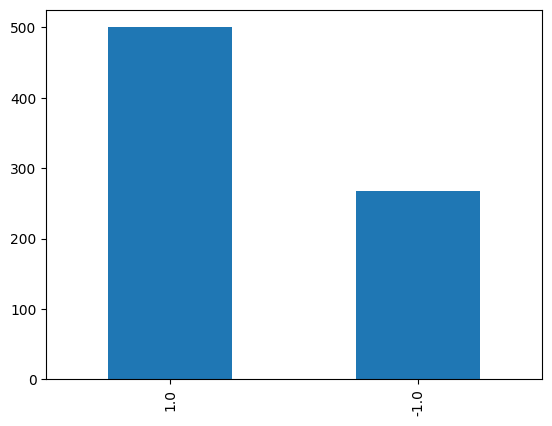

In [154]:
df['label'].value_counts().plot.bar()

The data does not seem to be balanced. There is almost double of positive class when compared to the negative class.

Let us look at the distribution of labels accross the 8 features.

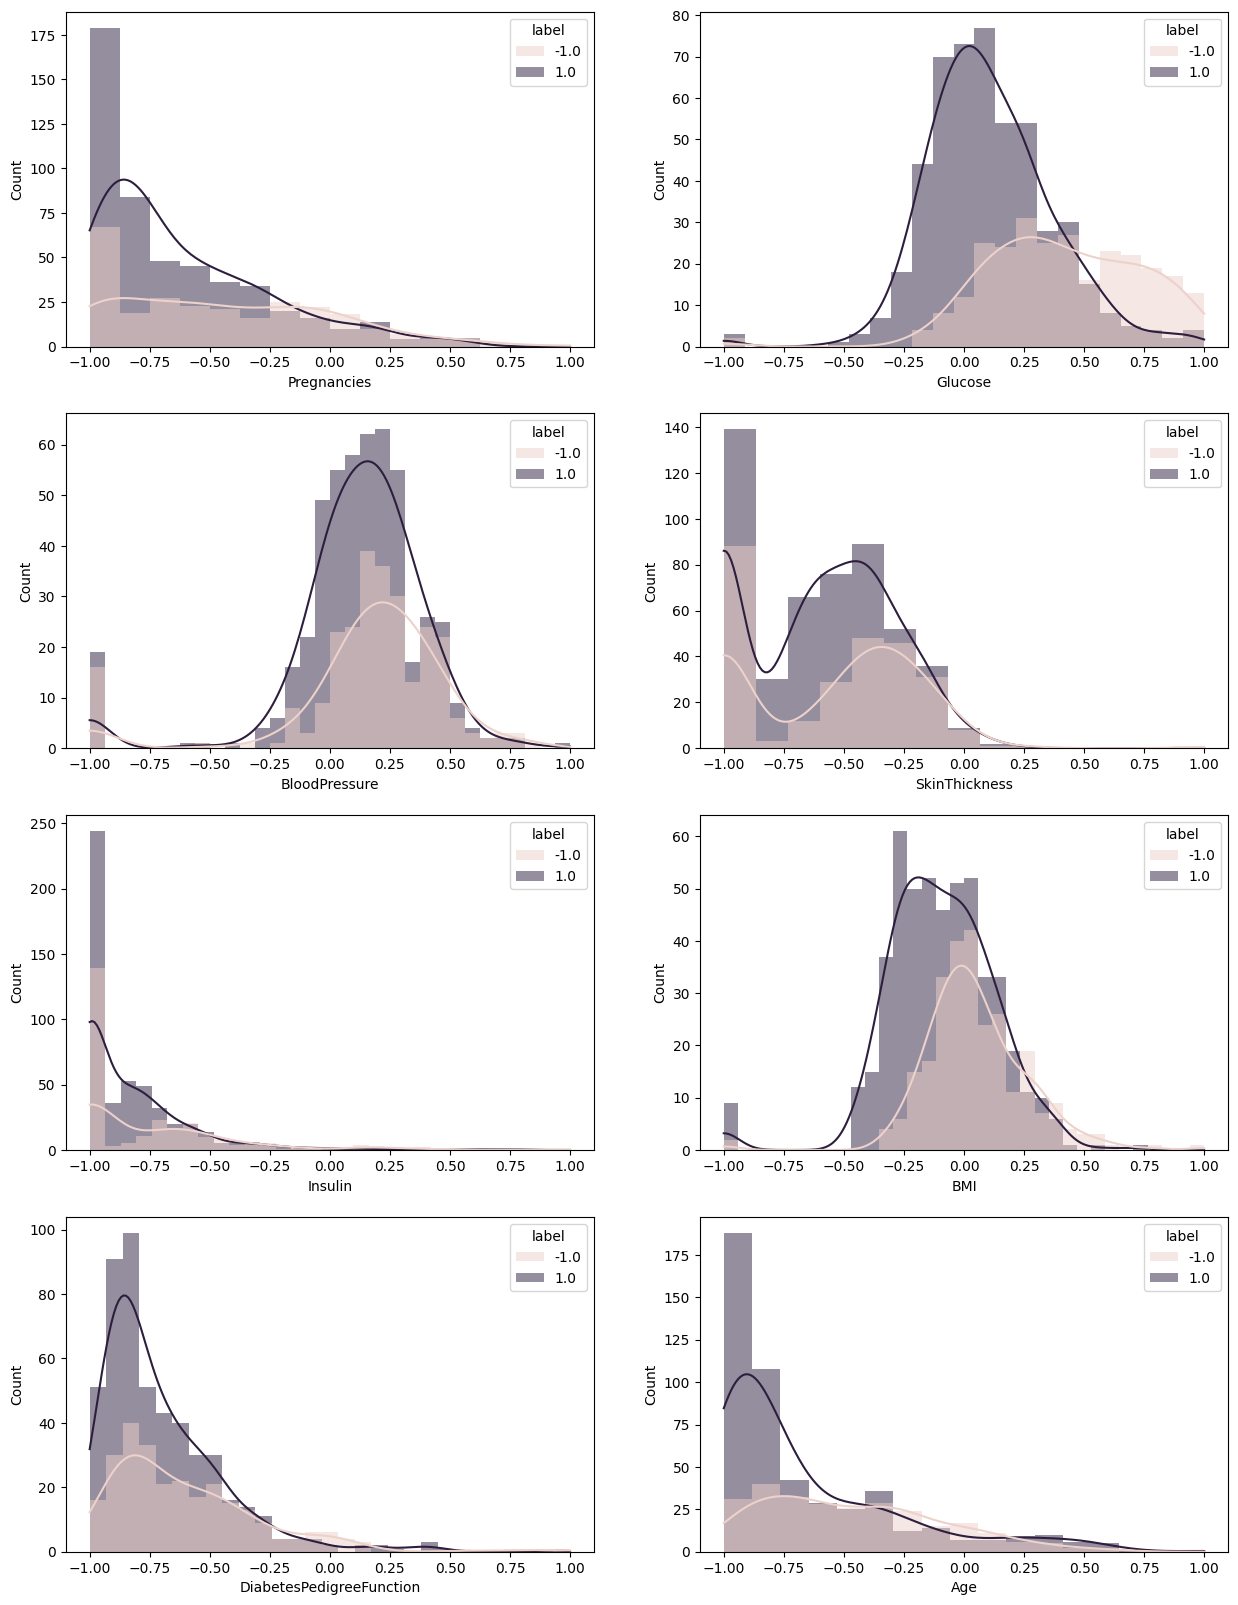

In [155]:
features = ['Pregnancies', 'Glucose', 'BloodPressure','SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(15, 20))
k=0
for i in range(0,4):
    for j in range(0,2):
            # show the plots
            sns.histplot(data=df, x=df[features[k]], hue="label", kde=True, ax=axes[i,j], edgecolor=None)
            k+=1

Let us now look at the correlation of features against each other. We have to remove highly correlated features

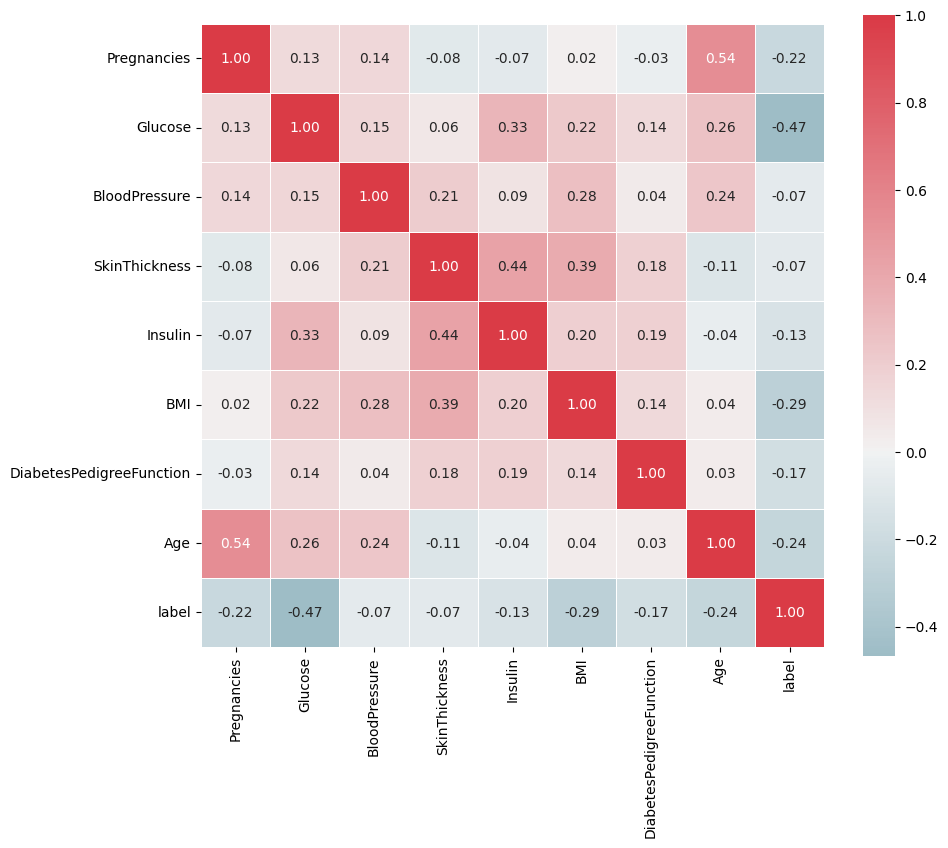

In [156]:
correlations = df.corr()
## Create color map ranging between two colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()


There are no high values so we can go forward without removing any features.

Lets now split the data into train, val and test.

Text(0.5, 0, 'Feature Importance')

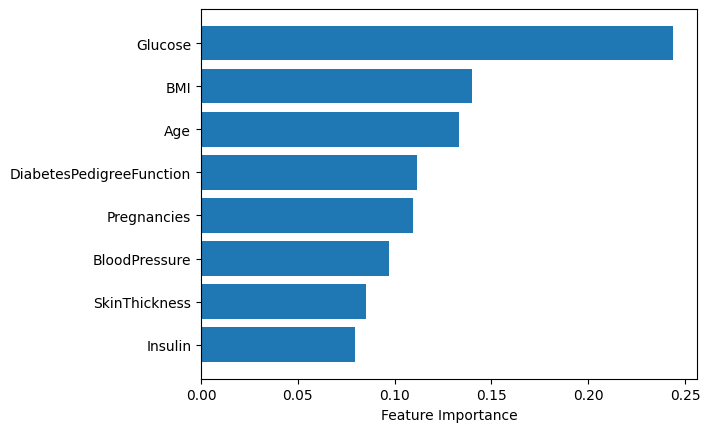

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

# train, test = train_test_split(df.values, test_size=0.25, random_state=42)
data = df.values

# create test split
train, test_set = train_test_split(data, test_size=.20, random_state=42, stratify=data[:,-1])
# create train and val
train_set, val_set = train_test_split(train, test_size=.20, random_state=42, stratify=train[:,-1])

y_train = train_set[:,-1]
X_train = train_set[:,0:-1]

y_val = val_set[:,-1]
X_val = val_set[:,0:-1]

y_test = test_set[:,-1]
X_test = test_set[:,0:-1]

rf = ExtraTreesClassifier(n_estimators=150)
rf.fit(X_train, y_train)

sort = rf.feature_importances_.argsort()

features_sorted = [features[i] for i in sort]
features_sorted_values = [rf.feature_importances_[i] for i in sort]


plt.barh(features_sorted, features_sorted_values)
plt.xlabel("Feature Importance")

We can see the feature importance in the above plot. It was calculated using a tree classifier.

Let us define some helper functions

In [158]:
# calculate mean squared error
def mse(t1, t2):
    diff = t1 - t2
    return np.sum(diff * diff) / len(diff)

# calculate accuracy
def accuracy(outputs, labels):
    return (np.sum(outputs == labels).item() / len(outputs))

In [159]:
X_train.shape

(491, 8)

## Baseline

In [160]:
y_train = np.where(y_train < 1 , 0, y_train)
y_test = np.where(y_test < 1 , 0, y_test)
y_val = np.where(y_val < 1 , 0, y_val)

In [161]:
from torch.utils.data import TensorDataset

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

In [162]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

In [163]:
import torch.nn as nn

input_size = 8
num_classes = 2

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, num_classes)
        


        
    def forward(self, xb):
        out = self.linear1(xb)
        
        return out
    
model = Model()

In [164]:
def accuracy_py(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [165]:
for features, labels in train_loader:
    print(features.dtype)
    break

torch.float32


In [166]:
epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
history=[]
output = []

for epoch in range(epochs):
    for batch in train_loader:
        imgs, labels = batch
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels.long())   # Calculate loss
        acc = accuracy_py(outputs, labels)           # Calculate accuracy
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for batch in val_loader:
        imgs, labels = batch
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels.long())   # Calculate loss
        acc = accuracy_py(outputs, labels)
        output.append({'val_loss': loss, 'val_acc': acc})

    batch_losses = [x['val_loss'] for x in output]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in output]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    history.append({'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()})
    print("epoch {}/{}, validation loss : {}, validation accuracy : {}".format(epoch, epochs, loss, acc))
    output.clear()

epoch 0/10, validation loss : 0.6300721764564514, validation accuracy : 0.6666666865348816
epoch 1/10, validation loss : 0.5967525243759155, validation accuracy : 0.6666666865348816
epoch 2/10, validation loss : 0.568954586982727, validation accuracy : 0.6666666865348816
epoch 3/10, validation loss : 0.5520195960998535, validation accuracy : 0.7037037014961243
epoch 4/10, validation loss : 0.536104142665863, validation accuracy : 0.7037037014961243
epoch 5/10, validation loss : 0.5244377851486206, validation accuracy : 0.7777777910232544
epoch 6/10, validation loss : 0.515444815158844, validation accuracy : 0.7777777910232544
epoch 7/10, validation loss : 0.505950391292572, validation accuracy : 0.7777777910232544
epoch 8/10, validation loss : 0.49823909997940063, validation accuracy : 0.8148148059844971
epoch 9/10, validation loss : 0.4936683475971222, validation accuracy : 0.8518518805503845


Text(0.5, 1.0, 'Loss vs. No. of epochs')

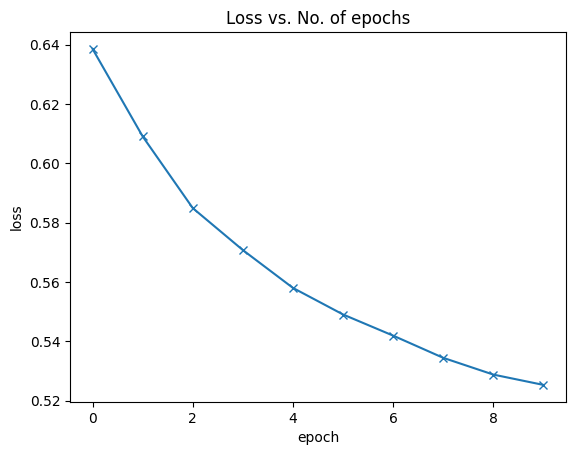

In [167]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

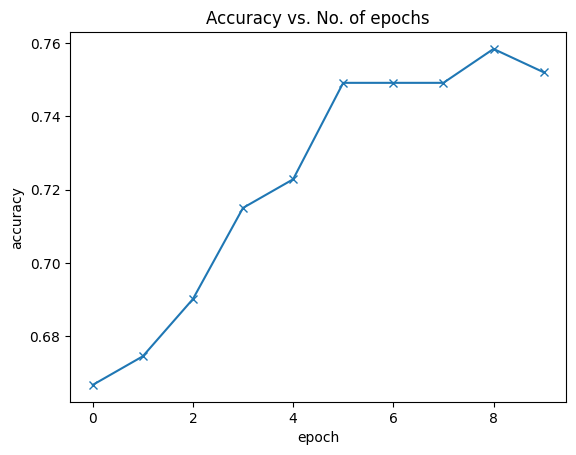

In [168]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [169]:
for batch in test_loader:
        imgs, labels = batch
        outputs = model(imgs)
        acc = accuracy_py(outputs, labels)
print("Test accuracy : {}%".format(acc.item()*100))

Test accuracy : 61.538463830947876%


## Perceptron

In [170]:
def plot_curves(history):
    losses = [x['val_loss'] for x in history]
    accuracies = [x['val_acc'] for x in history]

    plt.plot(losses, '-x', label='validation loss')
    plt.plot(accuracies, '-x',label='validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs')

In [171]:
def decision_boundary(train_set, best_weights):
    X_Train_embedded = TSNE(n_components=2).fit_transform(train_set[:,0:-1])
    y_predicted = outputs = np.sign(np.dot(train_set[:,0:-1], best_weights))

    # create meshgrid
    resolution = 100 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))
    colors = ListedColormap(['r','b'])

    #plot
    plt.contourf(xx, yy, voronoiBackground)
    scatter = plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=train_set[:,-1])
    plt.legend(handles=scatter.legend_elements()[0], labels=[ 'Diabetic', 'Healthy'], bbox_to_anchor = (1 , 1))

    plt.show()

In [172]:
def fit(epochs, w, lr, train_set, val_set):
    
    alpha = 0
    history = []
    best_val = 0
    best_weights = w
    for epoch in np.arange(0, epochs):

        # lets loop through each data point
        for sample in train_set:

            # get features and label
            y_train = sample[-1]
            X_train = sample[0:-1]
            

            # step function
            ind_func = 1 if y_train* np.dot(X_train, w) <0 else 0
            
            # summate over all samples
            alpha += (y_train*X_train * ind_func)
        
        # update weights
        w = w + alpha*lr

        
        # predict on val set
        outputs = np.sign(np.dot(val_set[:,0:-1], w))
        
        # calculate loss and accuracy
        loss = mse(outputs, val_set[:,-1])
        acc = accuracy(outputs, val_set[:,-1])
        
        if(acc>best_val):
            best_val = acc
            best_weights = w

        history.append({'val_loss': loss, 'val_acc': acc})
        print("epoch {}/{}, validation loss : {}, validation accuracy : {}".format(epoch, epochs, loss, acc))
    
    return history, best_weights

Hyperparmeter tuning of perceptron without bias

In [173]:

rates = [10, 1, 0.1, 0.001, 0.0001, 1e-5]
val_accuracies = []
# history, best_weights = fit(epochs=20, w=w, lr = 0.001, train_set = train_set, val_set = val_set)
for lr in rates:
    np.random.seed(45)
    w = np.random.randn(X_train.shape[-1])  
    history, best_weights = fit(epochs=20, w=w, lr = lr, train_set = train_set, val_set = val_set)
    val_accuracies.append([lr, np.max([x['val_acc'] for x in history])])

epoch 0/20, validation loss : 2.6016260162601625, validation accuracy : 0.34959349593495936
epoch 1/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 2/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 3/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 4/20, validation loss : 1.951219512195122, validation accuracy : 0.5121951219512195
epoch 5/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 6/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 7/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 8/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 9/20, validation loss : 1.5934959349593496, validation accuracy : 0.6016260162601627
epoch 10/20, validation loss : 1.3008130081300813, validation accuracy : 0.6747967479674797
epo

Display the results now

In [174]:
df_tune = pd.DataFrame(val_accuracies, columns=("Learning rate", "Val acc"))
df_tune

,Learning rate,Val acc
0,10.00000,0.796748
1,1.00000,0.796748
2,0.10000,0.788618
3,0.00100,0.780488
4,0.00010,0.715447
5,0.00001,0.715447


Let us train on the best parateetrs we found above

In [175]:
np.random.seed(45)
w = np.random.randn(X_train.shape[-1])  
history, best_weights = fit(epochs=20, w=w, lr = 10, train_set = train_set, val_set = val_set)


epoch 0/20, validation loss : 2.6016260162601625, validation accuracy : 0.34959349593495936
epoch 1/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 2/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 3/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 4/20, validation loss : 1.951219512195122, validation accuracy : 0.5121951219512195
epoch 5/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 6/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 7/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 8/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 9/20, validation loss : 1.5934959349593496, validation accuracy : 0.6016260162601627
epoch 10/20, validation loss : 1.3008130081300813, validation accuracy : 0.6747967479674797
epo

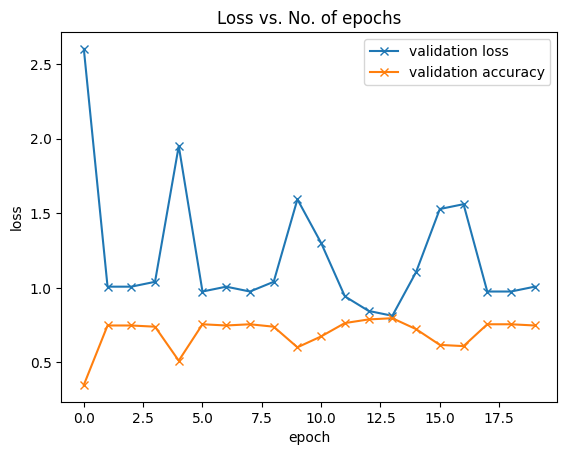

In [176]:
plot_curves(history)

In [177]:
outputs = np.sign(np.dot(test_set[:,0:-1], best_weights))
print("Test accuracy : {} %".format(np.sum(outputs == test_set[:,-1]).item() / len(outputs)*100))

Test accuracy : 74.02597402597402 %


/Users/aaron/ai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aaron/ai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


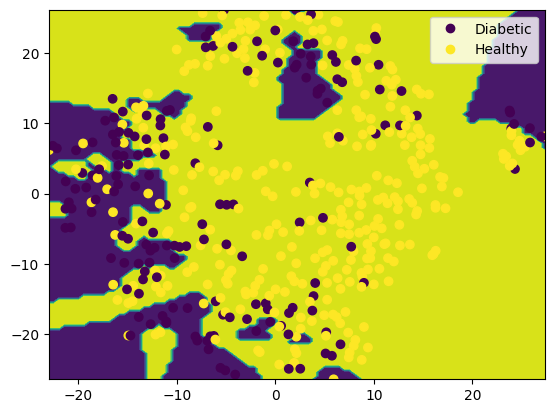

In [178]:
decision_boundary(train_set, best_weights)

In [179]:
def fit_bias(epochs, w, lr, train_set, val_set):
    
    alpha = 0
    history = []
    best_val = 0
    best_weights = w
    for epoch in np.arange(0, epochs):

        # lets loop through each data point
        for sample in train_set:

            # get features and label
            y_train = sample[-1]
            X_train = sample[0:-1]

            

            # step function
            ind_func = 1 if y_train* np.dot(X_train, w) <0 else 0
            
            # summate over all samples
            alpha += (y_train*X_train * ind_func)
        
        # update weights
        w = w + alpha*lr

        
        # predict on val set
        outputs = np.sign(np.dot(val_set[:,0:-1], w))
        
        # calculate loss and accuracy
        loss = mse(outputs, val_set[:,-1])
        acc = accuracy(outputs, val_set[:,-1])
        
        if(acc>best_val):
            best_val = acc
            best_weights = w

        history.append({'val_loss': loss, 'val_acc': acc})
        print("epoch {}/{}, validation loss : {}, validation accuracy : {}".format(epoch, epochs, loss, acc))
    
    return history, best_weights

In [180]:
# adding extra coloums to account for bias 
np.random.seed(45)
w = np.random.randn(X_train.shape[-1]+1)
print(w.shape)

val_set_new = val_set[:,0:-1]
ones = np.ones(val_set_new.shape[0]).reshape(-1,1)
# val_features = y = np.expand_dims(val_set[:-1], axis=1)
val_set_new = np.concatenate([val_set_new,ones, val_set[:,-1].reshape(-1,1)], axis=1)

train_set_new = train_set[:,0:-1]
ones = np.ones(train_set_new.shape[0]).reshape(-1,1)
train_set_new = np.concatenate([train_set_new,ones, train_set[:,-1].reshape(-1,1)], axis=1)

train_set_new.shape

(9,)


(491, 10)

In [181]:
rates = [10, 1, 0.1, 0.001, 0.0001, 1e-5]
val_accuracies = []
# history, best_weights = fit(epochs=20, w=w, lr = 0.001, train_set = train_set, val_set = val_set)
for lr in rates:
    np.random.seed(45)
    w = np.random.randn(X_train.shape[-1]+1)
    history, best_weights = fit_bias(epochs=20, w=w, lr = lr, train_set = train_set_new, val_set = val_set_new)
    val_accuracies.append([lr, np.max([x['val_acc'] for x in history])])

epoch 0/20, validation loss : 2.6016260162601625, validation accuracy : 0.34959349593495936
epoch 1/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 2/20, validation loss : 1.3333333333333333, validation accuracy : 0.6666666666666666
epoch 3/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 4/20, validation loss : 2.6341463414634148, validation accuracy : 0.34146341463414637
epoch 5/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 6/20, validation loss : 0.943089430894309, validation accuracy : 0.7642276422764228
epoch 7/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 8/20, validation loss : 1.170731707317073, validation accuracy : 0.7073170731707317
epoch 9/20, validation loss : 1.6260162601626016, validation accuracy : 0.5934959349593496
epoch 10/20, validation loss : 1.3333333333333333, validation accuracy : 0.6666666666666666
e

In [182]:
df_tune = pd.DataFrame(val_accuracies, columns=("Learning rate","Val acc"))
df_tune

,Learning rate,Val acc
0,10.00000,0.780488
1,1.00000,0.780488
2,0.10000,0.780488
3,0.00100,0.780488
4,0.00010,0.739837
5,0.00001,0.715447


In [183]:
np.random.seed(45)
w = np.random.randn(X_train.shape[-1]+1)
epochs = 20
lr = 10
# history, best_weights = fit(epochs=20, w=w, lr = 0.001, train_set = train_set, val_set = val_set)
history, best_weights = fit_bias(epochs=epochs, w=w, lr = lr, train_set = train_set_new, val_set = val_set_new)

epoch 0/20, validation loss : 2.6016260162601625, validation accuracy : 0.34959349593495936
epoch 1/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 2/20, validation loss : 1.3333333333333333, validation accuracy : 0.6666666666666666
epoch 3/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 4/20, validation loss : 2.6341463414634148, validation accuracy : 0.34146341463414637
epoch 5/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 6/20, validation loss : 0.943089430894309, validation accuracy : 0.7642276422764228
epoch 7/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 8/20, validation loss : 1.170731707317073, validation accuracy : 0.7073170731707317
epoch 9/20, validation loss : 1.6260162601626016, validation accuracy : 0.5934959349593496
epoch 10/20, validation loss : 1.3333333333333333, validation accuracy : 0.6666666666666666
e

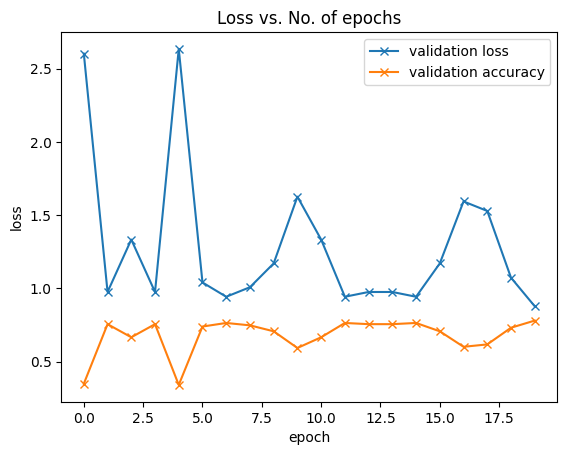

In [184]:
plot_curves(history)

In [185]:
test_set_new = test_set[:,0:-1]
ones = np.ones(test_set_new.shape[0]).reshape(-1,1)

test_set_new = np.concatenate([test_set_new,ones], axis=1)
outputs = np.sign(np.dot(test_set_new, best_weights))
print("Test accuracy : {} %".format(np.sum(outputs == test_set[:,-1]).item() / len(outputs)*100))

Test accuracy : 74.67532467532467 %


/Users/aaron/ai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aaron/ai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


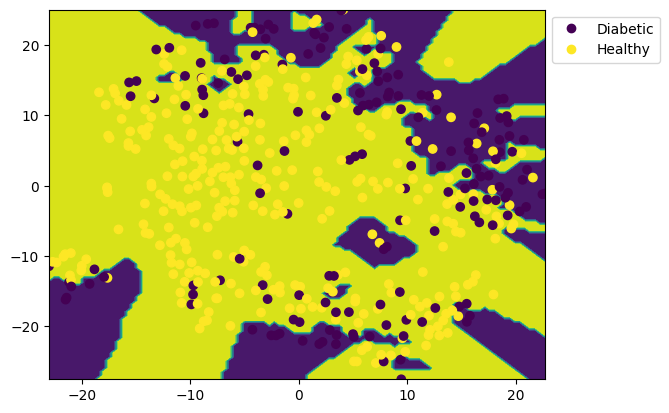

In [186]:
decision_boundary(train_set_new,best_weights)

Let us implemet perceptron with sigmoid function and weights updating after processing every sample

In [187]:
def fit_sigmoid(epochs, w, lr, train_set, val_set):
    
    alpha = 0
    history = []
    best_val = 0
    best_weights = w
    for epoch in np.arange(0, epochs):

        # lets loop through each data point
        for sample in train_set:

            # get features and label
            y_train = sample[-1]
            X_train = sample[0:-1]
            

            logistic = 1/(1+np.exp(-np.dot(X_train, w)))
            prediction = (1 if logistic>0.5 else -1)
            loss = (prediction-y_train)
            
            w = w - lr*X_train*loss
        
        outputs=[]
        for sample in val_set:
            val = sample[0:-1]
            logistic = 1/(1+np.exp(-np.dot(val, w)))
            outputs.append(1 if logistic>0.5 else -1)
            
        
        # calculate loss and accuracy
        loss = mse(outputs, val_set[:,-1])
        acc = accuracy(outputs, val_set[:,-1])
        
        if(acc>best_val):
            best_val = acc
            best_weights = w

        history.append({'val_loss': loss, 'val_acc': acc})
        print("epoch {}/{}, validation loss : {}, validation accuracy : {}".format(epoch, epochs, loss, acc))
    return history, best_weights

Let's initialize the weights randomly. It has more chances of reaching min optima faster than initalizing it as zeros.

In [188]:
rates = [10, 1, 0.1, 0.001, 0.0001, 1e-5]
val_accuracies = []
# history, best_weights = fit(epochs=20, w=w, lr = 0.001, train_set = train_set, val_set = val_set)
for lr in rates:
    np.random.seed(45)
    w = np.random.randn(X_train.shape[-1])  
    history, best_weights = fit_sigmoid(epochs=20, w=w, lr = lr, train_set = train_set, val_set = val_set)
    val_accuracies.append([lr, np.max([x['val_acc'] for x in history])])

epoch 0/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 1/20, validation loss : 0.943089430894309, validation accuracy : 0.7642276422764228
epoch 2/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 3/20, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 4/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 5/20, validation loss : 1.3333333333333333, validation accuracy : 0.6666666666666666
epoch 6/20, validation loss : 1.170731707317073, validation accuracy : 0.7073170731707317
epoch 7/20, validation loss : 1.008130081300813, validation accuracy : 0.7479674796747967
epoch 8/20, validation loss : 0.9105691056910569, validation accuracy : 0.7723577235772358
epoch 9/20, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838
epoch 10/20, validation loss : 1.1056910569105691, validation accuracy : 0.7235772357723578
epoc

In [189]:
df_tune = pd.DataFrame(val_accuracies, columns=("Learning rate", "Val acc"))
df_tune

,Learning rate,Val acc
0,10.00000,0.788618
1,1.00000,0.780488
2,0.10000,0.780488
3,0.00100,0.715447
4,0.00010,0.715447
5,0.00001,0.691057


Now lets train the perceptron

In [190]:
np.random.seed(45)
w = np.random.randn(X_train.shape[-1])
epochs = 5
lr = 10
# history, best_weights = fit(epochs=20, w=w, lr = 0.001, train_set = train_set, val_set = val_set)
history, best_weights = fit_sigmoid(epochs=epochs, w=w, lr = lr, train_set = train_set, val_set = val_set)


epoch 0/5, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 1/5, validation loss : 0.943089430894309, validation accuracy : 0.7642276422764228
epoch 2/5, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 3/5, validation loss : 0.975609756097561, validation accuracy : 0.7560975609756098
epoch 4/5, validation loss : 1.0406504065040652, validation accuracy : 0.7398373983739838


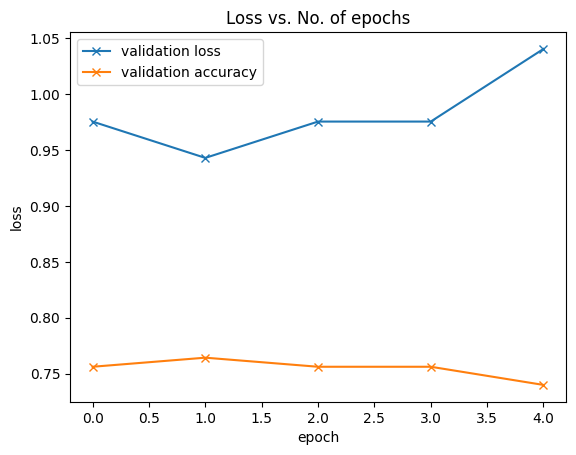

In [191]:
plot_curves(history)

In [192]:
outputs = np.sign(np.dot(test_set[:,0:-1], best_weights))
print("Test accuracy : {} %".format(np.sum(outputs == test_set[:,-1]).item() / len(outputs)*100))

Test accuracy : 73.37662337662337 %


/Users/aaron/ai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aaron/ai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


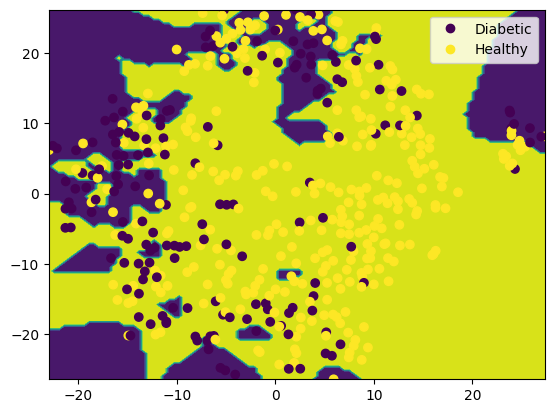

In [193]:
decision_boundary(train_set, best_weights)